In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

Estimated friction for Baseline run_in:
coulomb: 0.11288[Nm], (0.11482, -0.11095)
viscous: 0.00782 [Nm/(rev/s)], (0.00787, 0.00777)


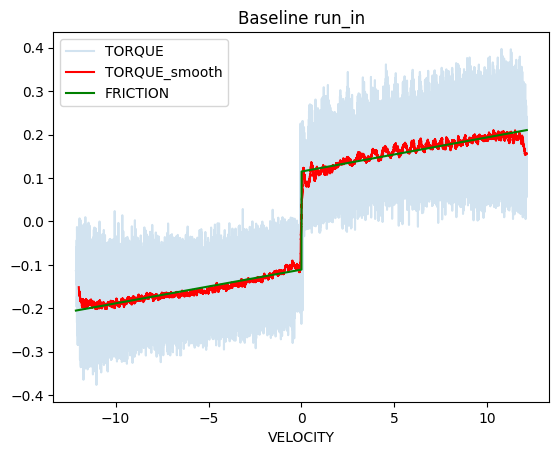

In [4]:
test_data = {
    # 'Motor only': '../../code/data/speedramp_2024-05-31_19-44-11.csv',
    # 'Baseline reducer': '../../../data/speedramp_baseline1_240s_14.0rps_06-13_10-36-37.csv',
    # 'Conic (no preload)': '../../../data/speedramp_360s_14.0rps_06-12_16-47-04.csv',
    # 'Baseline second assembly': '../../data/06-18_16-57-33_speedramp_baseline second assembly_240s_10.0rps.csv',
    'Baseline run_in': 'test_data/06-20_14-07-21_speedramp_Baseline PCCF_240s_12.0rps.csv'
}

def estimate_friction(df_vel_torque):
    # split data in positive and negative velocity
    positive_vt = df_vel_torque[df_vel_torque['VELOCITY'] > 0]
    negative_vt = df_vel_torque[df_vel_torque['VELOCITY'] < 0]

    # fit linear model
    pos_viscous, pos_coulomb,  = np.polyfit(positive_vt['VELOCITY'], positive_vt['TORQUE'], 1)
    neg_viscous, neg_coulomb,  = np.polyfit(negative_vt['VELOCITY'], negative_vt['TORQUE'], 1)

    # average
    coulomb = (pos_coulomb - neg_coulomb) / 2
    viscous = (pos_viscous + neg_viscous) / 2
    print(f'coulomb: {coulomb:.5f}[Nm], ({pos_coulomb:.5f}, {neg_coulomb:.5f})')
    print(f'viscous: {viscous:.5f} [Nm/(rev/s)], ({pos_viscous:.5f}, {neg_viscous:.5f})')

    #create model lines for pos and neg seperately
    pos_model = positive_vt.copy()
    pos_model['FRICTION'] = pos_viscous * pos_model['VELOCITY'] + pos_coulomb
    neg_model = negative_vt.copy()
    neg_model['FRICTION'] = neg_viscous * neg_model['VELOCITY'] + neg_coulomb

    # combine the two models
    fric_model = pd.concat([neg_model, pos_model])

    return fric_model

for name, path in test_data.items():
    #another test after cutting a bigger slot, and at a higher voltage:
    df_fric = pd.read_csv(path)
    vt_fric = df_fric[['VELOCITY', 'TORQUE']]
    vt_fric = vt_fric.sort_values(by='VELOCITY')
    vt_fric = vt_fric.reset_index(drop=True)

    vt_fric['TORQUE_smooth'] = vt_fric['TORQUE'].rolling(window=200).mean()

    # plot measurements
    fig, ax = plt.subplots()
    vt_fric.plot(x='VELOCITY', y='TORQUE', alpha=0.2, ax=ax)
    vt_fric.plot(x='VELOCITY', y='TORQUE_smooth', color='red', ax=ax)

    # plot estimated friction
    print(f'Estimated friction for {name}:')
    fric_model = estimate_friction(vt_fric)
    fric_model.plot(x='VELOCITY', y='FRICTION', color='green', ax=ax)

    plt.title(name)

    plt.show()